In [ ]:
DATA_DIR = "/content/mpd"           # сюда качаем ZIP'ы
EXTRACT_DIR = "/content/mpd_small"  # сюда выборочно распакуем срезы
BUDGET_GB = 8.0                     # сколько ГБ готовы занять распакованными JSON'ами (поменяй при желании)

In [ ]:
!pip -q install aicrowd-cli

import os
os.environ["AICROWD_API_KEY"] = "18608e23110510ec78259b3707943da3"  # <-- твой ключ
!mkdir -p "$DATA_DIR"
!aicrowd login --api-key $AICROWD_API_KEY


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.1 MB/s eta 0:00:00
API Key valid
Gitlab oauth token invalid or absent.
It is highly recommended to simply run `aicrowd login` without passing the API Key.
Saved details successfully!


In [ ]:
!aicrowd dataset download -c spotify-million-playlist-dataset-challenge -o "$DATA_DIR"
!ls -lh "$DATA_DIR"

spotify_million_playlist_dataset.zip: 100% 5.79G/5.79G [04:19<00:00, 22.3MB/s]
spotify_million_playlist_dataset_challenge.zip: 100% 113M/113M [00:04<00:00, 22.8MB/s]
total 5.5G
-rw-r--r-- 1 root root 109M Oct 13 10:24 spotify_million_playlist_dataset_challenge.zip
-rw-r--r-- 1 root root 5.4G Oct 13 10:24 spotify_million_playlist_dataset.zip


In [ ]:
import zipfile, os, math, re
from pathlib import Path

main_zip = Path(DATA_DIR) / "spotify_million_playlist_dataset.zip"
assert main_zip.exists(), "Не найден основной zip, проверь DATA_DIR"

EXTRACT_DIR = Path(EXTRACT_DIR)
EXTRACT_DIR.mkdir(parents=True, exist_ok=True)

slice_pat = re.compile(r"(?:^|/)(mpd\.slice\.(\d+)-(\d+)\.json)$")  # имя файла + номера

# Пройдёмся по файлам в архиве, отберём только mpd.slice.*.json и отсортируем по порядку
with zipfile.ZipFile(main_zip, 'r') as z:
    infos = []
    for info in z.infolist():
        m = slice_pat.search(info.filename)
        if m:
            fname = m.group(1)
            start = int(m.group(2))
            end = int(m.group(3))
            infos.append((start, end, info))
    infos.sort(key=lambda x: x[0])

    # Подберём набор, который вписывается в бюджет
    budget_bytes = int(BUDGET_GB * (1024**3))
    picked = []
    total = 0
    for start, end, info in infos:
        # распакованный json ≈ размер в zip * коэффициент_разжатия.
        # Возьмём грубый коэффициент 4.0 (JSONы обычно пухнут в 4-5 раз).
        estimated_unzipped = int(info.file_size * 4.0)
        if total + estimated_unzipped > budget_bytes:
            break
        picked.append(info)
        total += estimated_unzipped

    print(f"Планируем распаковать {len(picked)} срезов (~{total/1024**3:.2f} GB распакованного).")

    # Распаковка выбранных срезов
    for i, info in enumerate(picked, 1):
        out_path = EXTRACT_DIR / os.path.basename(info.filename)
        if not out_path.exists():
            z.extract(info, EXTRACT_DIR)
        print(f"[{i}/{len(picked)}] {out_path.name}")


Планируем распаковать 63 срезов (~7.93 GB распакованного).
[1/63] mpd.slice.0-999.json
[2/63] mpd.slice.1000-1999.json
[3/63] mpd.slice.2000-2999.json
[4/63] mpd.slice.3000-3999.json
[5/63] mpd.slice.4000-4999.json
[6/63] mpd.slice.5000-5999.json
[7/63] mpd.slice.6000-6999.json
[8/63] mpd.slice.7000-7999.json
[9/63] mpd.slice.8000-8999.json
[10/63] mpd.slice.9000-9999.json
[11/63] mpd.slice.10000-10999.json
[12/63] mpd.slice.11000-11999.json
[13/63] mpd.slice.12000-12999.json
[14/63] mpd.slice.13000-13999.json
[15/63] mpd.slice.14000-14999.json
[16/63] mpd.slice.15000-15999.json
[17/63] mpd.slice.16000-16999.json
[18/63] mpd.slice.17000-17999.json
[19/63] mpd.slice.18000-18999.json
[20/63] mpd.slice.19000-19999.json
[21/63] mpd.slice.20000-20999.json
[22/63] mpd.slice.21000-21999.json
[23/63] mpd.slice.22000-22999.json
[24/63] mpd.slice.23000-23999.json
[25/63] mpd.slice.24000-24999.json
[26/63] mpd.slice.25000-25999.json
[27/63] mpd.slice.26000-26999.json
[28/63] mpd.slice.27000-27999

In [ ]:
import glob
from pathlib import Path
slices = sorted(glob.glob(str(Path(EXTRACT_DIR) / "**" / "mpd.slice.*.json"), recursive=True))

In [ ]:
!pip -q install pyarrow

import json, pandas as pd
from pathlib import Path
import pyarrow as pa
import pyarrow.parquet as pq

out_parquet = Path(EXTRACT_DIR) / "mpd_tracks.parquet"
writer = None
total_rows = 0

for i, slc in enumerate(slices, 1):
    with open(slc, "r", encoding="utf-8") as f:
        data = json.load(f)

    rows = []
    for pl in data["playlists"]:
        pid = pl["pid"]
        title = pl.get("name", "")
        for t in pl["tracks"]:
            rows.append({
                "pid": pid,
                "playlist_title": title,
                "track_uri": t.get("track_uri"),
                "track_name": t.get("track_name"),
                "artist_uri": t.get("artist_uri"),
                "artist_name": t.get("artist_name"),
                "album_uri": t.get("album_uri"),
                "album_name": t.get("album_name"),
            })

    df = pd.DataFrame(rows)
    table = pa.Table.from_pandas(df, preserve_index=False)
    if writer is None:
        writer = pq.ParquetWriter(out_parquet, table.schema, compression="zstd")
    writer.write_table(table)

if writer is not None:
    writer.close()

#EDA

In [ ]:
df = pd.read_parquet(out_parquet)
df.head(3)

,pid,playlist_title,track_uri,track_name,artist_uri,artist_name,album_uri,album_name
0,0,Throwbacks,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,Lose Control (feat. Ciara & Fat Man Scoop),spotify:artist:2wIVse2owClT7go1WT98tk,Missy Elliott,spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,The Cookbook
1,0,Throwbacks,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,Toxic,spotify:artist:26dSoYclwsYLMAKD3tpOr4,Britney Spears,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,In The Zone
2,0,Throwbacks,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,Crazy In Love,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Beyoncé,spotify:album:25hVFAxTlDvXbx2X2QkUkE,Dangerously In Love (Alben für die Ewigkeit)


In [ ]:
df.shape

(4213122, 8)

In [ ]:
df.isna().mean().sort_values(ascending=False)

,0
pid,0.0
playlist_title,0.0
track_uri,0.0
track_name,0.0
artist_uri,0.0
artist_name,0.0
album_uri,0.0
album_name,0.0


###Пропусков нет

In [ ]:
print("Уникальных плейлистов:", df["pid"].nunique())
print("Уникальных треков:", df["track_uri"].nunique())
print("Уникальных артистов:", df["artist_uri"].nunique())
print("Уникальных альбомов:", df["album_uri"].nunique())

Уникальных плейлистов: 63000
Уникальных треков: 526994
Уникальных артистов: 89731
Уникальных альбомов: 218763


####Топ 10 песен:

In [ ]:
df["track_name"].value_counts().head(10)

,count
track_name,
Closer,4240
Home,3173
Roses,2825
HUMBLE.,2821
One Dance,2707
Congratulations,2554
Ride,2524
Broccoli (feat. Lil Yachty),2519
Let Me Love You,2393


####Топ 10 артистов:

In [ ]:
df["artist_name"].value_counts().head(10)

,count
artist_name,
Drake,51638
Kanye West,25861
Kendrick Lamar,21477
Rihanna,20796
The Weeknd,19119
Eminem,17982
Ed Sheeran,17254
Future,15708
J. Cole,15153


####Топ 10 альбомов:

In [ ]:
df["album_name"].value_counts().head(10)

,count
album_name,
Views,12664
Greatest Hits,9686
Stoney,9544
DAMN.,8594
More Life,8565
Beauty Behind The Madness,8493
Coloring Book,8264
American Teen,7503
Culture,7497


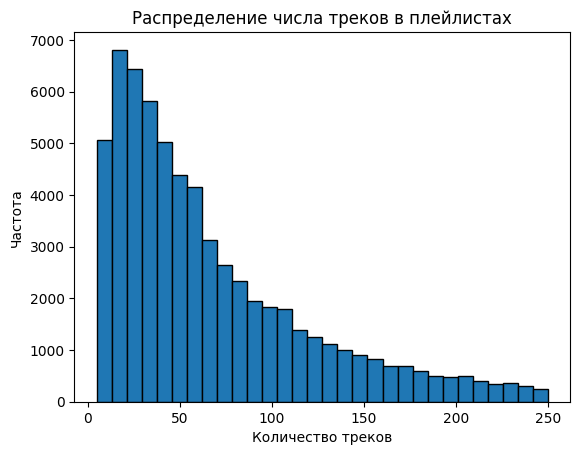

In [ ]:
import matplotlib.pyplot as plt
tracks_per_playlist = df.groupby("pid")["track_uri"].count()
tracks_per_playlist.describe()

tracks_per_playlist.plot(kind='hist', bins=30, edgecolor='black')
plt.title("Распределение числа треков в плейлистах")
plt.xlabel("Количество треков")
plt.ylabel("Частота")
plt.show()

####В основном в плейлисте до 50 треков

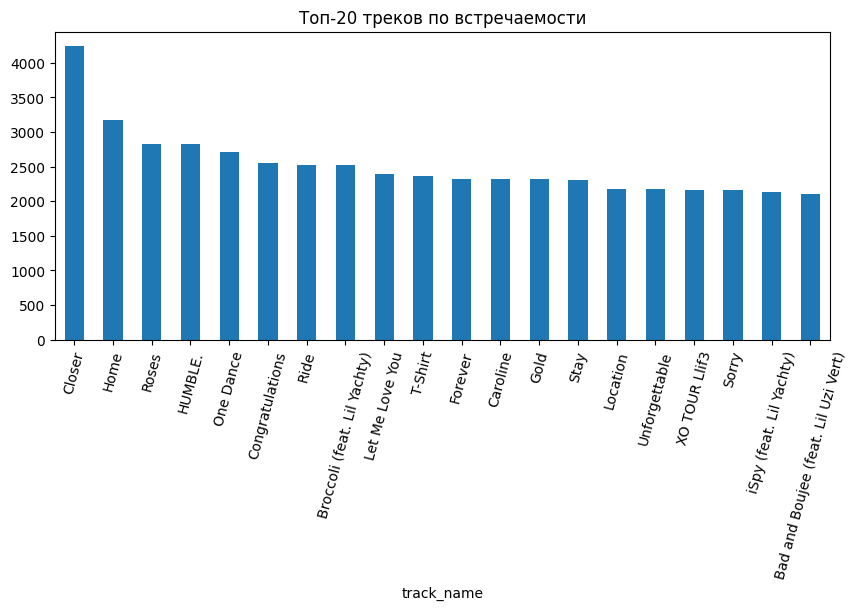

In [ ]:
track_popularity = df["track_name"].value_counts()
artist_popularity = df["artist_name"].value_counts()

plt.figure(figsize=(10,4))
track_popularity.head(20).plot(kind='bar')
plt.title("Топ-20 треков по встречаемости")
plt.xticks(rotation=75)
plt.show()

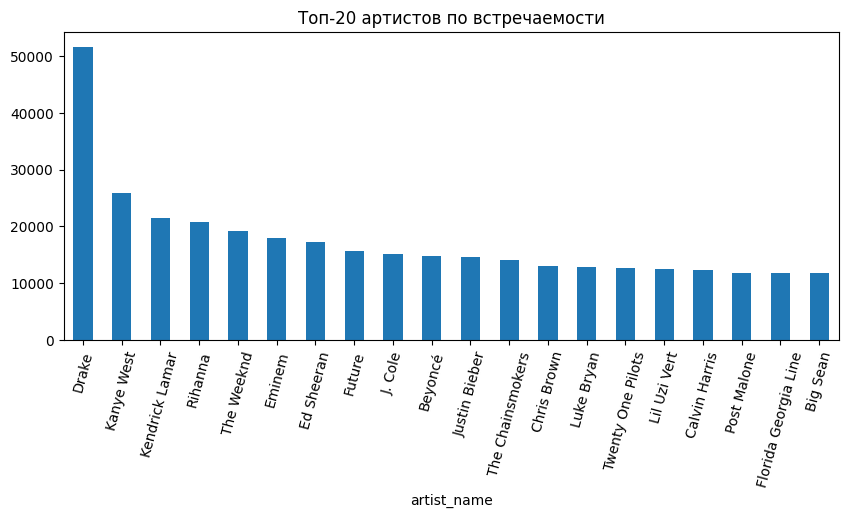

In [ ]:
plt.figure(figsize=(10,4))
artist_popularity.head(20).plot(kind='bar')
plt.title("Топ-20 артистов по встречаемости")
plt.xticks(rotation=75)
plt.show()

#Системы рекомендаций:

###1) KNN по трекам

In [ ]:
from collections import defaultdict, Counter

pl2tracks = df.groupby("pid")["track_uri"].apply(list).to_dict()

track2pls = defaultdict(list)
for pid, tracks in pl2tracks.items():
    for t in tracks:
        track2pls[t].append(pid)

track_pop = df["track_uri"].value_counts()
artist_pop = df["artist_uri"].value_counts()
album_pop  = df["album_uri"].value_counts()

In [ ]:
track2meta = df.groupby("track_uri").agg({
    "track_name":"first", "artist_uri":"first", "artist_name":"first",
    "album_uri":"first", "album_name":"first"
}).to_dict(orient="index")

artist2tracks = df.groupby("artist_uri")["track_uri"].apply(list).to_dict()
album2tracks  = df.groupby("album_uri")["track_uri"].apply(list).to_dict()

In [ ]:
def get_playlist_tracks(pid):
    if pid not in pl2tracks:
        raise ValueError(f"pid {pid} не найден в данных")
    return set(pl2tracks[pid])

def pretty_print(tracks, k=10):
    rows = []
    for t in list(tracks)[:k]:
        m = track2meta.get(t, {})
        rows.append(f"- {m.get('track_name','<unknown>')} — {m.get('artist_name','<unknown>')}")
    print("\n".join(rows))

In [ ]:
def rec_item_knn_for_pid(pid, k=50, topn_neighbors=200, alpha=0.75):
  seeds = list(get_playlist_tracks(pid))
  have = set(seeds)
  cand_scores = Counter() # суммарные очки кандидатов
  seed_weight = 1 / len(seeds)
  for s in seeds:
    pls = track2pls.get(s, [])
    neighbor_counts = Counter()
    for p in pls:
        for t in pl2tracks[p]:
            if t == s:
                continue
            neighbor_counts[t] += 1
    s_df = len(pls) + 1e-9
    for t, co in neighbor_counts.most_common(topn_neighbors):
        t_df = len(track2pls.get(t, [])) + 1e-9
        base = co / math.sqrt(s_df * t_df)
        pop = track_pop.get(t, 1)
        score = base / (pop ** (1 - alpha))
        cand_scores[t] += score * seed_weight
  recs = [t for t, _ in cand_scores.most_common() if t not in have]
  return recs[:k]

In [ ]:
pretty_print(rec_item_knn_for_pid(0, k=10))

1208
- Hollaback Girl — Gwen Stefani
- The Sweet Escape — Gwen Stefani
- Umbrella — Rihanna
- Burnin' Up — Jonas Brothers
- Girlfriend (German Version - Explicit) - German Version - Explicit — Avril Lavigne
- Don't Cha — Busta Rhymes
- One, Two Step — Ciara
- Down — Jay Sean
- Fergalicious — Fergie
- Complicated — Avril Lavigne


In [ ]:
import random

def train_test_split_playlists(df, test_ratio=0.2, seed=42):
    random.seed(seed)
    train_rows, test_rows = [], []

    for pid, group in df.groupby("pid"):
        tracks = group["track_uri"].tolist()
        if len(tracks) < 5:
            train_rows.extend(group.to_dict("records"))
            continue
        n_test = max(1, int(len(tracks) * test_ratio))
        test_idx = set(random.sample(range(len(tracks)), n_test))
        for i, row in enumerate(group.to_dict("records")):
            if i in test_idx:
                test_rows.append(row)
            else:
                train_rows.append(row)

    return pd.DataFrame(train_rows), pd.DataFrame(test_rows)

df_train, df_test = train_test_split_playlists(df, test_ratio=0.2)

In [ ]:
def recall_at_k(recs, truth, k=10):
    if not truth:
        return 0.0
    rec_topk = recs[:k]
    hits = len(set(rec_topk) & set(truth))
    return hits / len(truth)

In [ ]:
import math

def ndcg_at_k(recs, truth, k=10):
    if not truth:
        return 0.0
    dcg = 0.0
    for i, r in enumerate(recs[:k]):
        if r in truth:
            dcg += 1 / math.log2(i + 2)
    ideal_dcg = sum(1 / math.log2(i + 2) for i in range(min(k, len(truth))))
    return dcg / ideal_dcg if ideal_dcg > 0 else 0.0

In [ ]:
import numpy as np

def novelty_at_k(recs, k=10):
    if len(recs) == 0:
        return 0.0
    pops = np.array([track_pop.get(t, 1) for t in recs[:k]])
    norm_pops = pops / pops.sum()
    return -np.sum(norm_pops * np.log2(norm_pops + 1e-9))

In [ ]:
def diversity_by_artist(recs, k=10):
    arts = [track2meta.get(t, {}).get("artist_name") for t in recs[:k]]
    arts = [a for a in arts if a]
    return len(set(arts)) / len(arts) if arts else 0.0

In [ ]:
pl2tracks = df_train.groupby("pid")["track_uri"].apply(list).to_dict()

from collections import defaultdict
track2pls = defaultdict(list)
for pid, tracks in pl2tracks.items():
    for t in tracks:
        track2pls[t].append(pid)

track_pop = df_train["track_uri"].value_counts()

In [ ]:
def evaluate_model(rec_func, df_train, df_test, k=10, n_playlists=200):
    pids = df_test["pid"].unique()
    sample_pids = random.sample(list(pids), min(n_playlists, len(pids)))

    metrics = {"recall": [], "ndcg": [], "novelty": [], "diversity": []}
    for pid in sample_pids:
        truth = set(df_test[df_test["pid"] == pid]["track_uri"])
        recs = rec_func(pid, k=k)
        metrics["recall"].append(recall_at_k(recs, truth, k))
        metrics["ndcg"].append(ndcg_at_k(recs, truth, k))
        metrics["novelty"].append(novelty_at_k(recs, k))
        metrics["diversity"].append(diversity_by_artist(recs, k))

    result = {m: round(np.mean(v), 4) for m, v in metrics.items()}
    return result

results = evaluate_model(lambda pid, k: rec_item_knn_for_pid(pid, k=k), df_train, df_test, k=10)
results

{'recall': np.float64(0.0706),
 'ndcg': np.float64(0.109),
 'novelty': np.float64(2.9897),
 'diversity': np.float64(0.7455)}

**Recall@K = 0.07**

Модель угадывает 7% спрятанных треков

Для сабсета MPD норм.

**NDCG@K = 0.109**

Правильные треки попадают довольно высоко в топ

**novelty = 3**.

Хорошая новизна —  рекомендации не просто сплошь мейнстрим. Чем выше, тем более редкие треки

**diversity = 0.75**

Неплохое разнообразие артистов
то есть у меня 68% уникальных артистов в топе



###2) Artist/Album-based

In [ ]:
from collections import defaultdict, Counter
import math

def rec_content_simple(pid, k=50, backfill=False):
    """
    Контентные рекомендации по артистам/альбомам из плейлиста pid.
    Параметры:
      - k: размер выдачи
      - backfill: если кандидатов < k, добиваем популярными треками
    Зависимости (должны быть подготовлены): df, track_pop, artist2tracks, album2tracks,
                                            pl2tracks/get_playlist_tracks, track2pls, track2meta
    """
    have = get_playlist_tracks(pid)
    subset = df[df["pid"] == pid]
    seed_artists = subset["artist_uri"].unique().tolist()
    seed_albums  = subset["album_uri"].unique().tolist()

    # если пусто — fallback
    if not seed_artists and not seed_albums:
        return rec_popularity_for_pid(pid, k)

    # внутренние «разумные» константы без экспонирования наружу
    PER_ARTIST_CAP = 2      # максимум рекомендаций от артиста
    PER_ALBUM_CAP  = 1      # максимум рекомендаций с альбома
    MIN_TRACK_POP  = 2      # отсечь совсем редчайший мусор
    # лёгкий штраф гиперпопсы (не трогаем снаружи)
    def _pop_weight(pop):
        return pop ** 0.85   # мягко

    # локальные частоты внутри плейлиста
    a_freq = Counter(subset["artist_uri"])
    al_freq = Counter(subset["album_uri"])

    # кандидаты по артистам
    artist_buckets = defaultdict(list)
    for a in seed_artists:
        trks = artist2tracks.get(a, [])
        scored = []
        for t in trks:
            if t in have:
                continue
            pop = track_pop.get(t, 0)
            if pop < MIN_TRACK_POP:
                continue
            score = (1 + math.log1p(a_freq[a])) * _pop_weight(pop)
            scored.append((score, t))
        scored.sort(reverse=True)
        artist_buckets[a] = [t for _, t in scored[:PER_ARTIST_CAP]]

    # кандидаты по альбомам
    album_buckets = defaultdict(list)
    for al in seed_albums:
        trks = album2tracks.get(al, [])
        if not trks:
            continue
        scored = []
        for t in trks:
            if t in have:
                continue
            pop = track_pop.get(t, 0)
            if pop < MIN_TRACK_POP:
                continue
            score = (1 + math.log1p(al_freq[al])) * _pop_weight(pop)
            scored.append((score, t))
        scored.sort(reverse=True)
        album_buckets[al] = [t for _, t in scored[:PER_ALBUM_CAP]]

    # round-robin чередование артистов/альбомов (60/40 автоматически)
    def round_robin(buckets, limit):
        keys = [k for k in buckets if buckets[k]]
        out, seen = [], set()
        i = 0
        while len(out) < limit and keys:
            k_ = keys[i % len(keys)]
            if buckets[k_]:
                t = buckets[k_].pop(0)
                if t not in seen:
                    out.append(t); seen.add(t)
            if not buckets[k_]:
                keys.remove(k_)
                # не инкрементим i здесь, чтобы не перепрыгнуть
                continue
            i += 1
        return out

    na = int(k * 0.6)  # автоматическая доля под артистов
    artist_part = round_robin(artist_buckets, na)
    album_part  = round_robin(album_buckets, k - len(artist_part))

    cand = artist_part + album_part
    # print(len(cand))

    # if backfill and len(cand) < k:
    #     need = k - len(cand)
    #     tail = [t for t in track_pop.index if t not in have and t not in cand]
    #     cand.extend(tail[:need])

    # seen, final = set(), []
    # for t in cand:
    #     if t not in seen:
    #         final.append(t); seen.add(t)
    #     if len(final) >= k:
    #         break
    return cand

In [ ]:
pretty_print(rec_content_simple(0, k=10))

- Work It — Missy Elliott
- Toxic — Britney Spears
- Halo — Beyoncé
- CAN'T STOP THE FEELING! (Original Song from DreamWorks Animation's "TROLLS") — Justin Timberlake
- Angel — Shaggy
- I Don't Mind — Usher
- We Run This (Without Manicure Interlude) — Missy Elliott
- Toxic — Britney Spears
- Naughty Girl — Beyoncé
- Cry Me a River — Justin Timberlake


In [ ]:
results = evaluate_model(lambda pid, k: rec_content_simple(pid, k=k), df_train, df_test, k=10)
results

{'recall': np.float64(0.1282),
 'ndcg': np.float64(0.1844),
 'novelty': np.float64(2.5796),
 'diversity': np.float64(0.6217)}

####Метрики получились похожие с педыдущим алгоритмом: recall и ndcg немного больше, novelty и diversity немного меньше

In [ ]:
def rec_popularity_for_pid(pid, k=50):
    have = get_playlist_tracks(pid)
    recs = [t for t in track_pop.index if t not in have]
    return recs[:k]

pretty_print(rec_popularity_for_pid(0, k=10))

- HUMBLE. — Kendrick Lamar
- One Dance — Drake
- Closer — The Chainsmokers
- Broccoli (feat. Lil Yachty) — DRAM
- Congratulations — Post Malone
- Caroline — Aminé
- XO TOUR Llif3 — Lil Uzi Vert
- Location — Khalid
- iSpy (feat. Lil Yachty) — KYLE
- Bad and Boujee (feat. Lil Uzi Vert) — Migos


In [ ]:
results = evaluate_model(lambda pid, k: rec_popularity_for_pid(pid, k=k), df_train, df_test, k=10)
results

{'recall': np.float64(0.0048),
 'ndcg': np.float64(0.0067),
 'novelty': np.float64(3.3136),
 'diversity': np.float64(0.9945)}